# Jul 5th, 2022 (Fig-7: Entropy)

**Motivation**:  <br>

In [1]:
# HIDE CODE


import os
import sys
from pprint import pprint
from copy import deepcopy as dc
from os.path import join as pjoin
from scipy.ndimage import gaussian_filter
from IPython.display import display, IFrame, HTML

# tmp & extras dir
git_dir = pjoin(os.environ['HOME'], 'Dropbox/git')
extras_dir = pjoin(git_dir, 'jb-Ca-fMRI/_extras')
fig_base_dir = pjoin(git_dir, 'jb-Ca-fMRI/figs')
tmp_dir = pjoin(git_dir, 'jb-Ca-fMRI/tmp')

# GitHub
sys.path.insert(0, pjoin(git_dir, '_Ca-fMRI'))
from figures.fighelper import *
from analysis.final import *
from utils.render import *

# warnings, tqdm, & style
warnings.filterwarnings('ignore', category=DeprecationWarning)
from tqdm.notebook import tqdm
%matplotlib inline
set_style()

## Fig dir

In [2]:
nn = 512
perc = 15
fig_dir = 'Fig7_Entropy'
fig_dir = pjoin(fig_base_dir, 'paper2.0', f'n{nn}-p{perc}', fig_dir)
os.makedirs(fig_dir, exist_ok=True)
print(fig_dir)

kws_fig = {
    'transparent': True,
    'bbox_inches': 'tight',
    'dpi': 300,
}

/home/hadi/Dropbox/git/jb-Ca-fMRI/figs/paper2.0/n512-p15/Fig7_Entropy

## Prepare (512)

In [3]:
num_k = 7
mice = Mice(nn)
bt_dict, props_bo, props_ca = default_props(mice, num_k, perc)
bt = BootStrap(**props_ca)
pal = prepare_palette()

## Entropy

In [4]:
%%time

for mode, o in bt_dict.items():
    o.compute_entropy(
        use_prune=True,
        select_seeds=False,
    )

CPU times: user 9.8 s, sys: 5.63 s, total: 15.4 s
Wall time: 20.9 s


In [5]:
%%time

cut, se, bins, xs = cut4figs('h', bt_dict, bt.get_booter(int(1e3)))
len(xs), len(bins)

CPU times: user 58.6 s, sys: 8.01 s, total: 1min 6s
Wall time: 1min 6s


(50, 51)

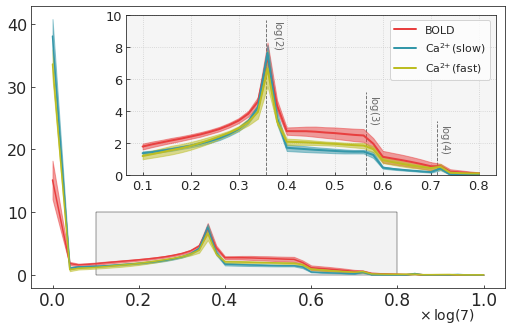

In [6]:
from figures.fig_ent import dist_ent_inset as go
fig, *_ = go(cut, se, xs, num_k, True)

fig.savefig(pjoin(fig_dir, 'dist.pdf'), **kws_fig)
fig.savefig(pjoin(fig_dir, 'dist.png'), **kws_fig)

In [13]:
ent = {mode: avg(o.run_h, 1) for mode, o in bt_dict.items()}
{mode: bt.symmetry_score(avg(h, 1))[0][-1] for mode, h in ent.items()}

{'BOLD': 0.847, 'Ca$^{2\\!\\!+}$(slow)': 0.909, 'Ca$^{2\\!\\!+}$(fast)': 0.909}

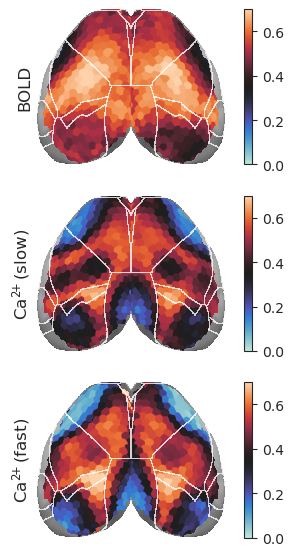

In [14]:
_ = bt.show(
    data=ent,
    figsize=(5, 7),
    vmin=0,
    vmax=0.7,
    add_disjoint=False,
    cmap='icefire',
    cbar=True,
)

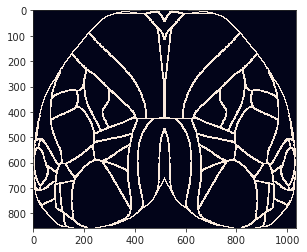

In [15]:
contour = bt.get_contour(0.2, False)
plt.imshow(contour);

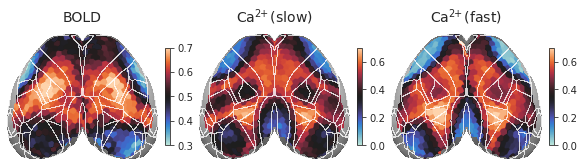

In [18]:
fig, axes = create_figure(1, 3, (8, 2.8), tight_layout=False, constrained_layout=True)
for ax, (mode, x) in zip(axes.flat, ent.items()):
    if mode == BOLD:
        vmin = np.nanmin(x)
        vmin = 0.3
    else:
        vmin = 0
    vmax = 0.7
    
    ax = ctx2ax(
        x=x,
        ax=ax,
        base=bt,
        vmin=vmin,
        vmax=vmax,
        cmap='icefire',
        cbar_shrink=0.5,
        contour=contour,
    )
    ax.set_title(mode, y=1.05, fontsize=14)
remove_ticks(axes)

# fig.savefig(pjoin(fig_dir, 'ctx.pdf'), **kws_fig)
fig.savefig(pjoin(fig_dir, 'ctx.png'), **kws_fig)

plt.show()

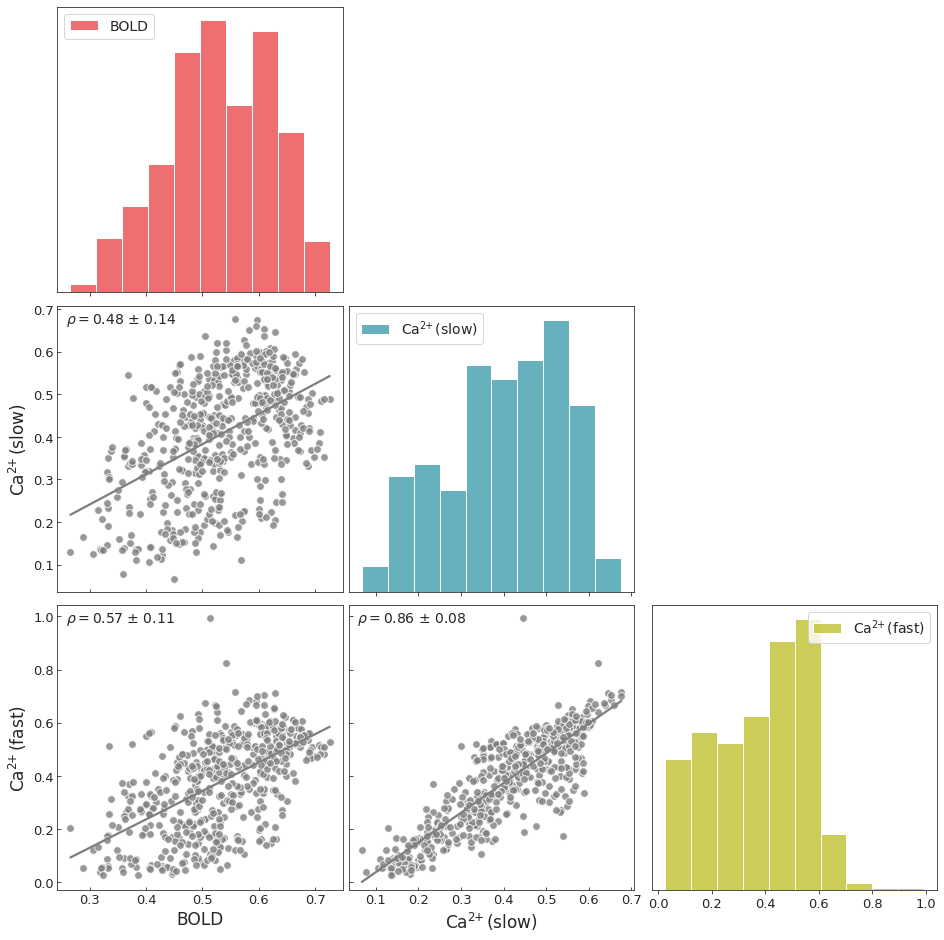

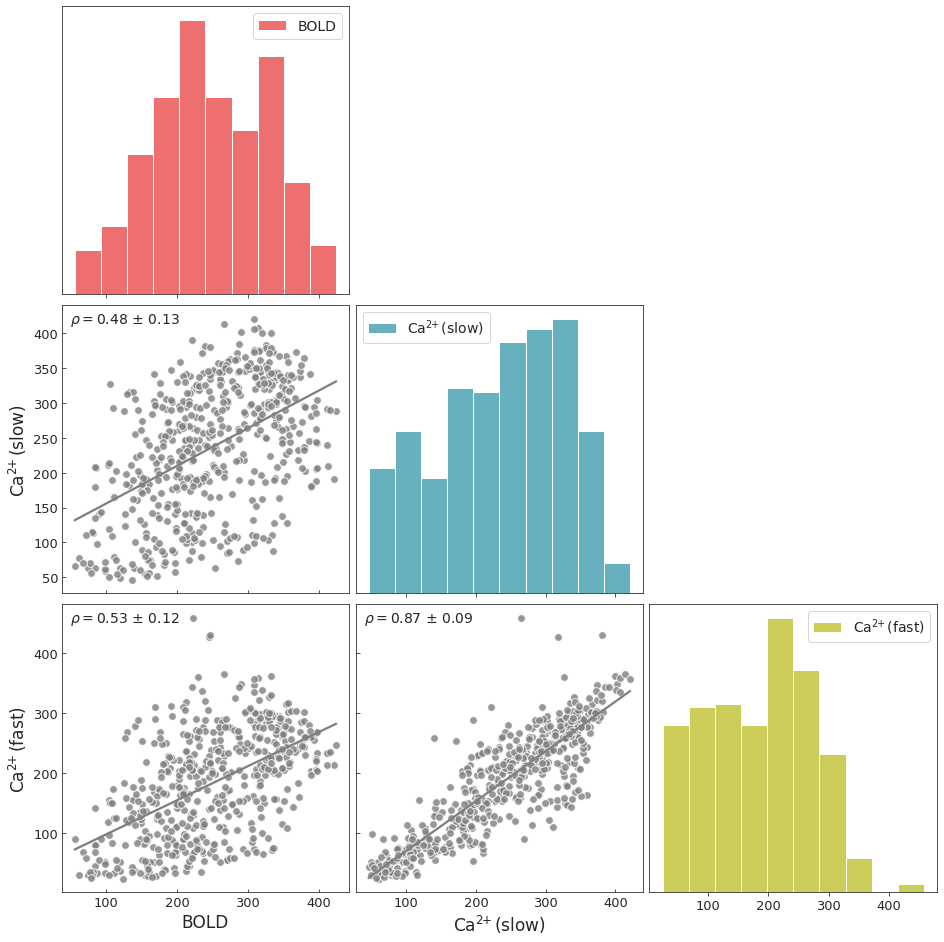

CPU times: user 36.2 s, sys: 790 ms, total: 37 s
Wall time: 8.82 s


In [19]:
%%time

fig, _ = pairwise(
    attr='h',
    bt_dict=bt_dict,
    n_resamples=int(1e3),
)
fig.savefig(pjoin(fig_dir, 'pairwise.pdf'), **kws_fig)
fig.savefig(pjoin(fig_dir, 'pairwise.png'), **kws_fig)


fig, _ = pairwise(
    attr='hr',
    bt_dict=bt_dict,
    n_resamples=int(1e3),
)
fig.savefig(pjoin(fig_dir, 'pairwise_rank.pdf'), **kws_fig)
fig.savefig(pjoin(fig_dir, 'pairwise_rank.png'), **kws_fig)

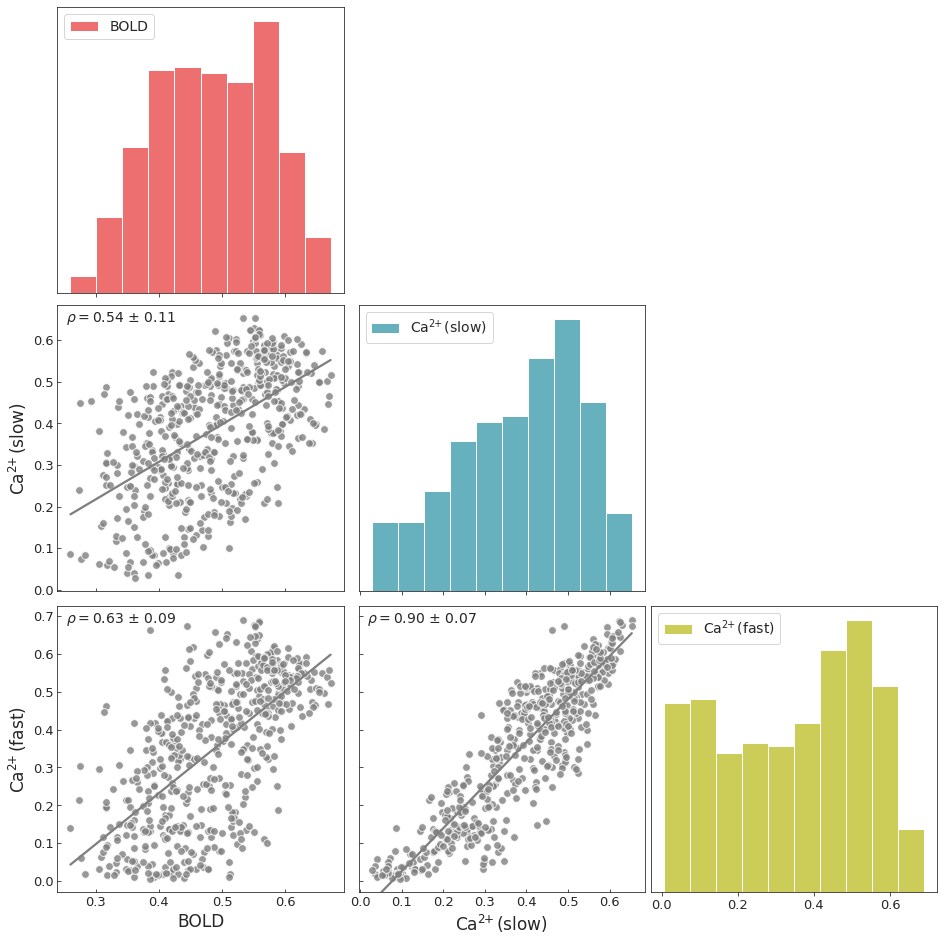

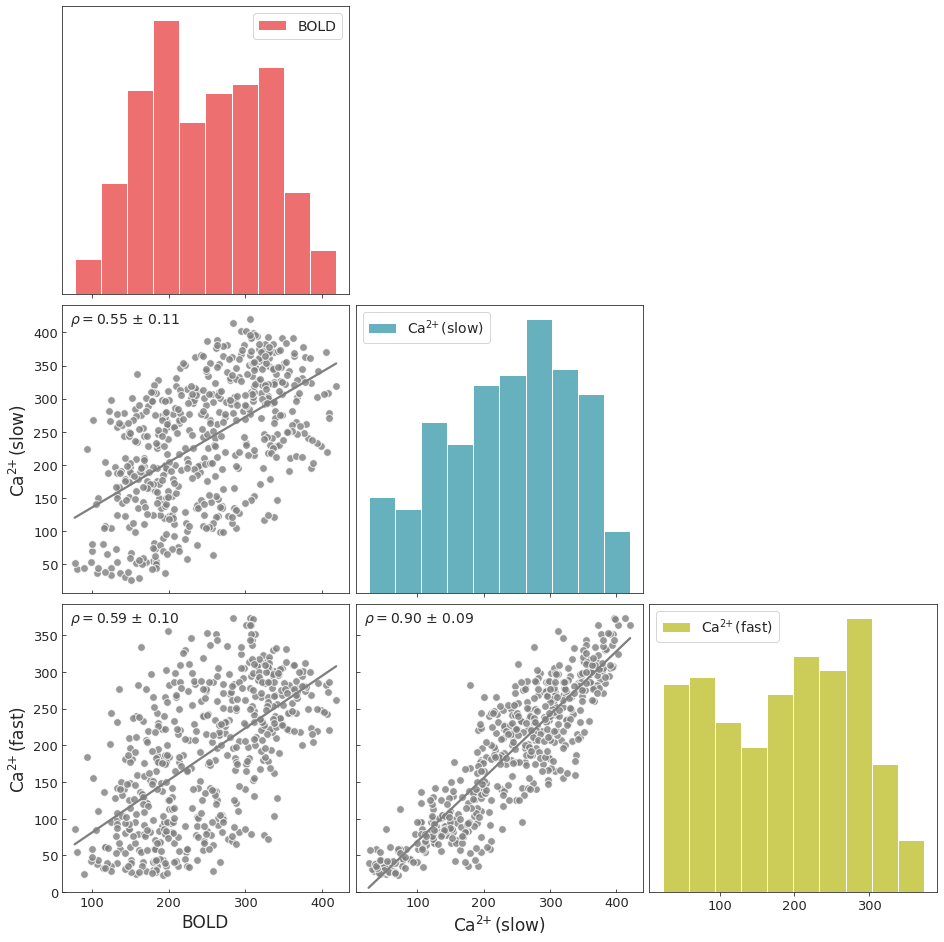

CPU times: user 35.7 s, sys: 646 ms, total: 36.3 s
Wall time: 7.63 s


In [13]:
for i, fig_name in {0: 'BOLD', 1: 'CAS', 2: 'CAF'}.items():
    fig, ax = create_figure(1, 1, (3, 2.5), tight_layout=False, constrained_layout=True)
    mode, x = list(ent.items())[i]

    if mode == _BOLD:
        vmin = np.nanmin(x)
        vmin = 0.3
    else:
        vmin = 0
    vmax = np.nanmax(x)
    
    ax = ctx2ax(
        x=x,
        ax=ax,
        base=bt,
        vmin=vmin,
        vmax=vmax,
        cmap='icefire',
        cbar_shrink=0.5,
        contour=contour,
    )
    
    ax.set_title(mode, y=1.05, fontsize=14)
    remove_ticks(ax)
    
    # fig.savefig(pjoin(fig_dir, f'ctx_{fig_name}.pdf'), **kws_fig)
    fig.savefig(pjoin(fig_dir, f'ctx_{fig_name}.png'), **kws_fig)
    
    plt.close()

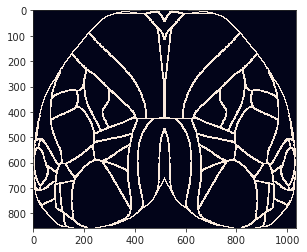

In [13]:
contour = bt.get_contour(0.2, False)
plt.imshow(contour);

## Permutation test

In [20]:
def statistic(a, b, axis):
    return bn.nanmean(a - b, axis=axis)

### Actual values

In [21]:
y = {}
for mode, o in bt_dict.items():
    y[mode] = o.run_h.reshape(-1, o.run_h.shape[-1])

good_runs = ~functools.reduce(
    np.logical_or,
    [np.isnan(e).sum(1) == e.shape[-1] for e in y.values()]
)
y = {k: v[good_runs] for k, v in y.items()}

good_runs.sum()

108

In [22]:
%%time

results = {}
for mode1, mode2 in itertools.combinations(y, 2):
    test = sp_stats.permutation_test(
        data=(y[mode1], y[mode2]),
        statistic=statistic,
        permutation_type='samples',
        alternative='two-sided',
        n_resamples=int(1e5),
        vectorized=True,
        random_state=42,
        batch=5,
        axis=0,
    )
    reject = np_nans(len(test.pvalue))
    pvals = np_nans(len(test.pvalue))
    nonan = np.isfinite(test.pvalue)

    corrected = multipletests(
        pvals=test.pvalue[nonan],
        alpha=0.05,
        method='fdr_bh',
        is_sorted=False,
        returnsorted=False,
    )
    reject[nonan] = corrected[0]
    pvals[nonan] = corrected[1]

    results[(mode1, mode2)] = test.statistic, reject, pvals

CPU times: user 6min, sys: 2.05 s, total: 6min 2s
Wall time: 6min 2s


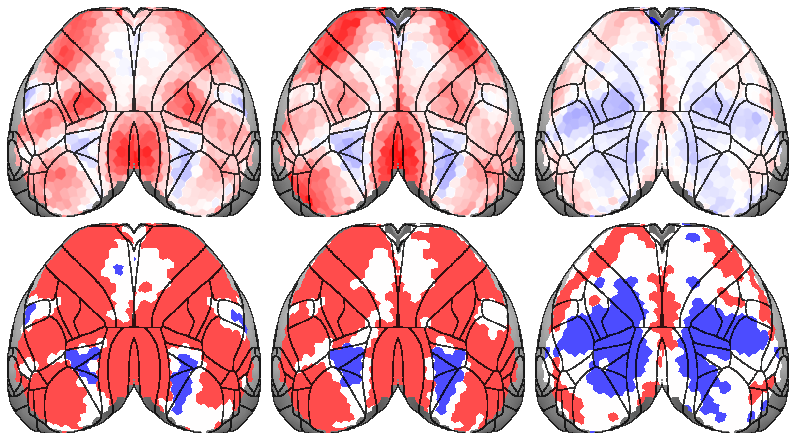

In [26]:
fig, axes = create_figure(
    2,
    3,
    (11, 6),
    tight_layout=False,
    constrained_layout=True,
)
for i, ((lbl_1, lbl_2), (s, r, p)) in enumerate(results.items()):
    ax = axes[0, i]
    vminmax = 0.5
    ax = ctx2ax(
        x=s,
        ax=ax,
        base=bt,
        vmin=-vminmax,
        vmax=vminmax,
        cmap='bwr',
        cbar=False,
        contour=contour,
        contour_cmap='Greys_r',
        interp='antialiased',
    )
    # ax.set_title(f"{lbl_1} - {lbl_2}", y=1.05, fontsize=17)

    cmap = sns.color_palette('bwr', as_cmap=True)
    cmap = matplotlib.colors.ListedColormap(
        [cmap(0.15), cmap(0.5), cmap(0.85)])
    ax = axes[1, i]
    x = s.copy()
    x[x < 0] = -1
    x[x > 0] = 1
    x[r == 0] = 0
    ax = ctx2ax(
        x=x,
        ax=ax,
        base=bt,
        vmin=-1,
        vmax=1,
        cmap=cmap,
        cbar=False,
        contour=contour,
        contour_cmap='Greys_r',
        interp='antialiased',
    )
remove_ticks(axes)

fig.savefig(pjoin(fig_dir, 'perm.png'), **kws_fig)

plt.show()

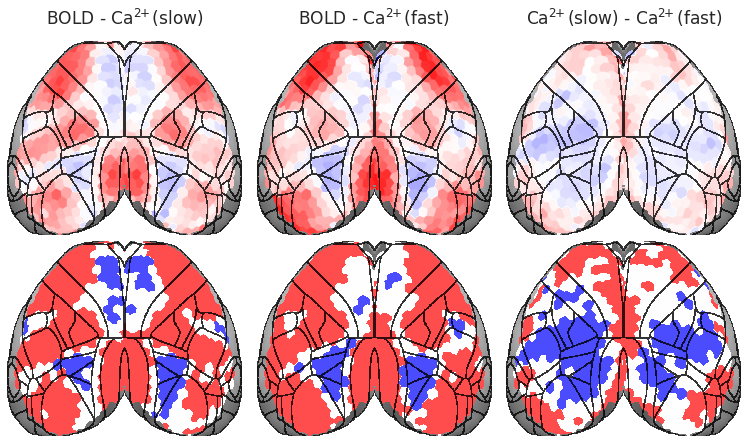

### Ranks

In [27]:
y = {}
for mode, o in bt_dict.items():
    y[mode] = o.run_hr.reshape(-1, o.run_hr.shape[-1])

good_runs = ~functools.reduce(
    np.logical_or,
    [np.isnan(e).sum(1) == e.shape[-1] for e in y.values()]
)
y = {k: v[good_runs] for k, v in y.items()}

good_runs.sum()

108

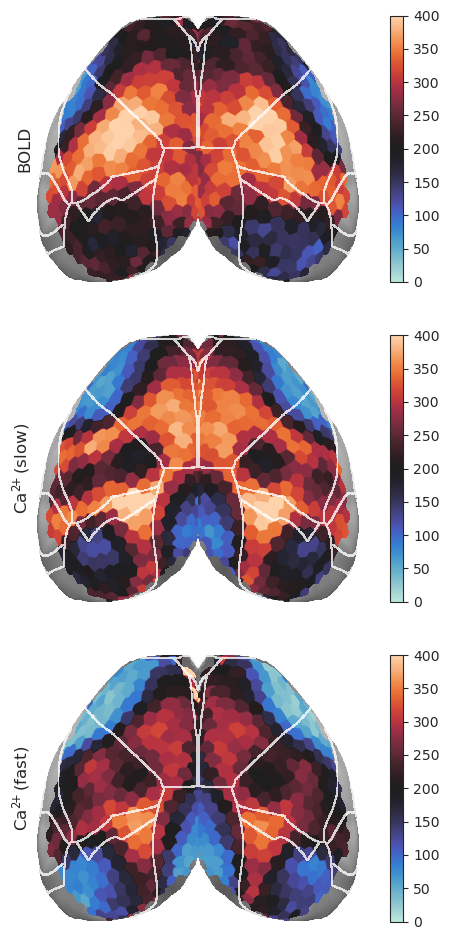

In [28]:
_ = bt.show(
    data={k: bn.nanmean(v, 0) for k, v in y.items()},
    figsize=(8, 12),
    vmin=0,
    vmax=400,
    add_disjoint=False,
    cmap='icefire',
    cbar=True,
)

In [29]:
entr = {mode: avg(o.run_hr, 1) for mode, o in bt_dict.items()}

for i, fig_name in {0: 'BOLD', 1: 'CAS', 2: 'CAF'}.items():
    fig, ax = create_figure(1, 1, (3, 2.5), tight_layout=False, constrained_layout=True)
    mode, x = list(entr.items())[i]

    vmin = 0
    vmax = 400
    
    ax = ctx2ax(
        x=x,
        ax=ax,
        base=bt,
        vmin=vmin,
        vmax=vmax,
        cmap='icefire',
        cbar_shrink=0.5,
        contour=contour,
    )
    
    ax.set_title(mode, y=1.05, fontsize=14)
    remove_ticks(ax)
    
    # fig.savefig(pjoin(fig_dir, f'ctx_{fig_name}.pdf'), **kws_fig)
    fig.savefig(pjoin(fig_dir, f'ctx_rank_{fig_name}.png'), **kws_fig)
    
    plt.close()

In [30]:
%%time

results = {}
for mode1, mode2 in itertools.combinations(y, 2):
    test = sp_stats.permutation_test(
        data=(y[mode1], y[mode2]),
        statistic=statistic,
        permutation_type='samples',
        alternative='two-sided',
        n_resamples=int(1e4),
        vectorized=True,
        random_state=42,
        batch=5,
        axis=0,
    )
    reject = np_nans(len(test.pvalue))
    pvals = np_nans(len(test.pvalue))
    nonan = np.isfinite(test.pvalue)

    corrected = multipletests(
        pvals=test.pvalue[nonan],
        alpha=0.05,
        method='fdr_bh',
        is_sorted=False,
        returnsorted=False,
    )
    reject[nonan] = corrected[0]
    pvals[nonan] = corrected[1]
    
    results[(mode1, mode2)] = test.statistic, reject, pvals

CPU times: user 30.7 s, sys: 75.9 ms, total: 30.8 s
Wall time: 30.8 s


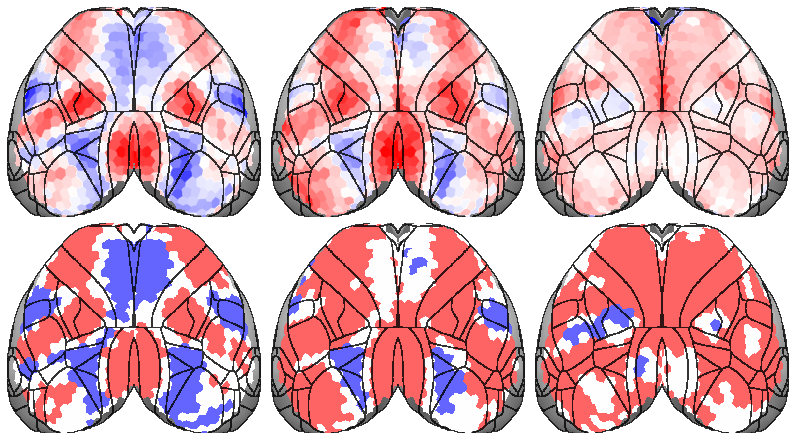

In [31]:
fig, axes = create_figure(2, 3, (11, 6), tight_layout=False, constrained_layout=True)
for i, ((lbl_1, lbl_2), (s, r, p)) in enumerate(results.items()):
    ax = axes[0, i]
    vminmax = 250
    ax = ctx2ax(
        x=s,
        ax=ax,
        base=bt,
        vmin=-vminmax,
        vmax=vminmax,
        cmap='bwr',
        cbar=False,
        contour=contour,
        contour_cmap='Greys_r',
    )
    # ax.set_title(f"{lbl_1} - {lbl_2}", y=1.07, fontsize=17)
    
    ax = axes[1, i]
    x = s.copy()
    x[x < 0] = -1
    x[x > 0] = 1
    x[r == 0] = 0
    vminmax = 1.65
    ax = ctx2ax(
        x=x,
        ax=ax,
        base=bt,
        vmin=-vminmax,
        vmax=vminmax,
        cmap='bwr',
        cbar=False,
        cbar_shrink=0.7,
        contour=contour,
        contour_cmap='Greys_r',
        interp='none',
    )
remove_ticks(axes)

fig.savefig(pjoin(fig_dir, 'perm_rank.png'), **kws_fig)

plt.show()

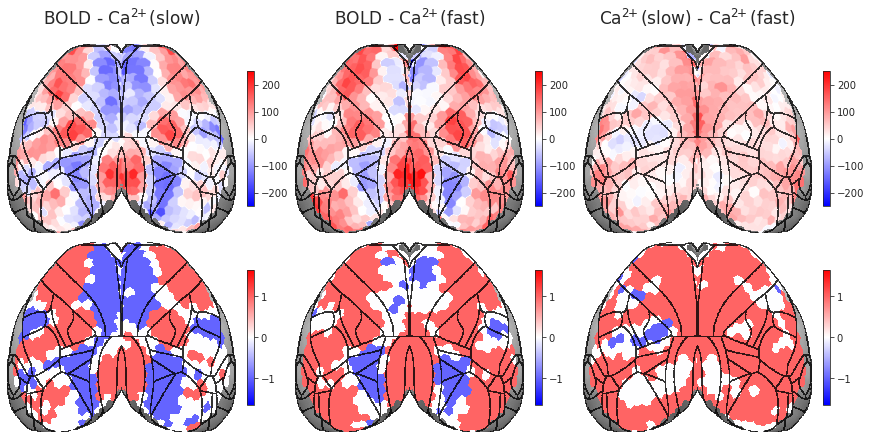

### Continue from below

---

## What about other K?

In [23]:
%%time

results = {}
for kk in tqdm([3, 7, 20]):
    props_ca['num_k'] = kk
    props_bo['num_k'] = kk

    bt_bo = BootStrap(**props_bo)

    mice.setup_func_data(task, band_ca=(0.01, 0.5))
    bt_cas = BootStrap(**props_ca)

    mice.setup_func_data(task, band_ca=0.5)
    bt_caf = BootStrap(**props_ca)

    bt_dict = {
        _BOLD: bt_bo,
        _CAS: bt_cas,
        _CAF: bt_caf,
    }
    for mode, o in bt_dict.items():
        if mode == _BOLD and kk in [3, 7]:
            seeds = True
        else:
            seeds = False
        o.compute_entropy(
            use_prune=True,
            select_seeds=seeds,
        )
    results[kk] = bt_dict

  0%|          | 0/3 [00:00<?, ?it/s]

CPU times: user 4min 36s, sys: 1min 22s, total: 5min 58s
Wall time: 5min 58s


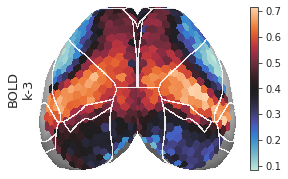

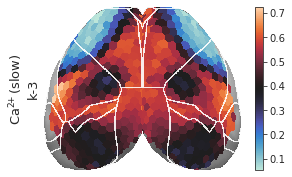

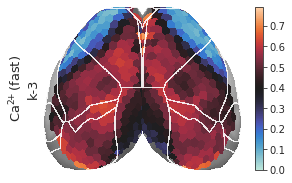

----------------------------------------

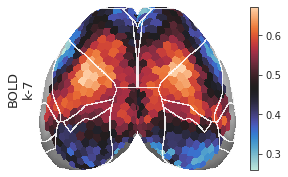

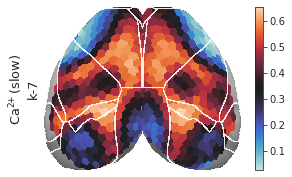

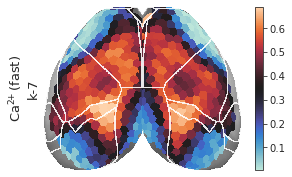

----------------------------------------

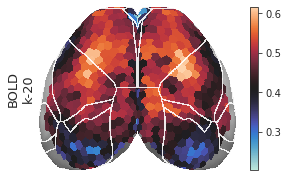

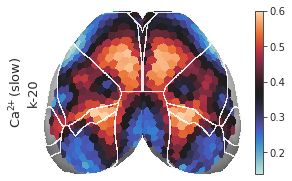

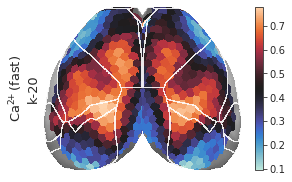

----------------------------------------

In [25]:
for kk, dd in results.items():
    for mode, o in dd.items():
        x = avg(o.run_h, 1)
        _ = bt.show(
            data={f"{mode}\nk-{kk}": x},
            cmap='icefire',
            vmin=np.nanmin(x),
            vmax=np.nanmax(x),
            figsize=(5, 3),
            cbar=True,
            add_disjoint=False,
        )
    print('-' * 40)

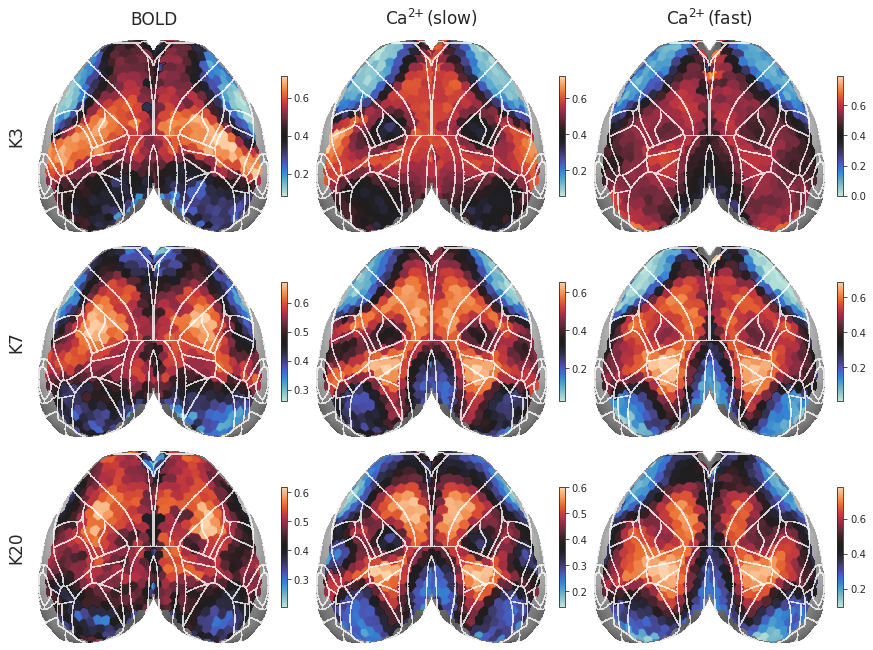

In [146]:
fig, axes = create_figure(
    3,
    3,
    (12, 9),
    tight_layout=False,
    constrained_layout=True,
)

vmin = None
vmax = None

for i, (kk, dd) in enumerate(results.items()):
    for j, (mode, o) in enumerate(dd.items()):
        ax = axes[i, j]
        x = avg(o.run_h, 1)
        ax = ctx2ax(
            x=x,
            ax=ax,
            base=bt,
            vmin=vmin,
            vmax=vmax,
            cmap='icefire',
            cbar_shrink=0.6,
            contour=contour,
        )
        if i == 0:
            ax.set_title(mode, y=1.05, fontsize=17)
        if j == 0:
            ax.set_ylabel(f"K{kk}", fontsize=17, labelpad=13)
        remove_ticks(ax)
        
fig.savefig(pjoin(fig_dir, 'all_k_ctx.png'), **kws_fig)
plt.show()

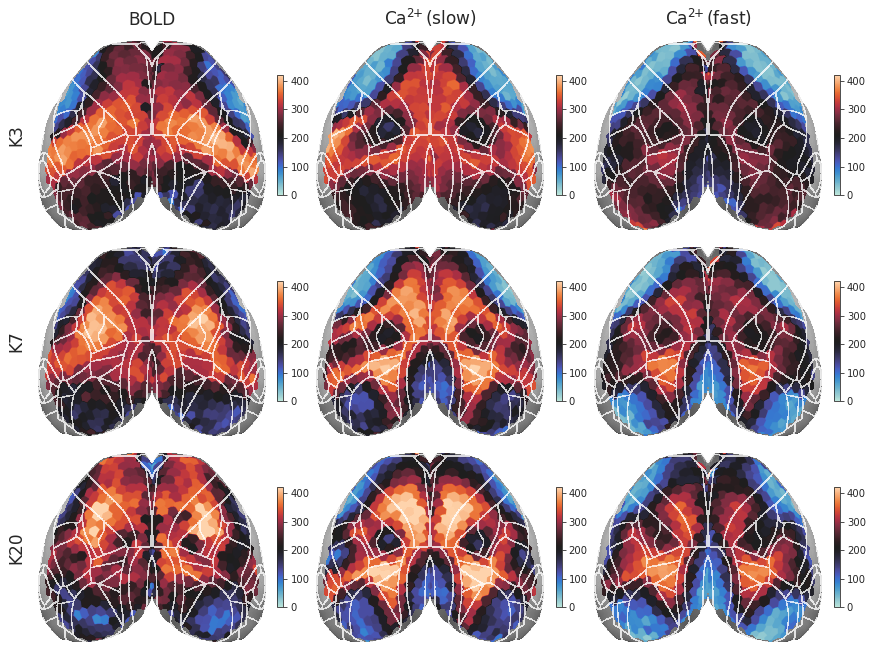

In [147]:
fig, axes = create_figure(
    3,
    3,
    (12, 9),
    tight_layout=False,
    constrained_layout=True,
)

vmin = 0
vmax = 420

for i, (kk, dd) in enumerate(results.items()):
    for j, (mode, o) in enumerate(dd.items()):
        ax = axes[i, j]
        x = avg(o.run_hr, 1)
        ax = ctx2ax(
            x=x,
            ax=ax,
            base=bt,
            vmin=vmin,
            vmax=vmax,
            cmap='icefire',
            cbar_shrink=0.6,
            contour=contour,
        )
        if i == 0:
            ax.set_title(mode, y=1.05, fontsize=17)
        if j == 0:
            ax.set_ylabel(f"K{kk}", fontsize=17, labelpad=13)
        remove_ticks(ax)
        
fig.savefig(pjoin(fig_dir, 'all_k_rank_ctx.png'), **kws_fig)
plt.show()

In [148]:
h_all = collections.defaultdict(list)
hr_all = collections.defaultdict(list)
for i, (kk, dd) in enumerate(results.items()):
    for j, (mode, o) in enumerate(dd.items()):
        x = avg(o.run_h, 1)
        h_all[mode].append(np.expand_dims(x, 0))
        x = avg(o.run_hr, 1)
        hr_all[mode].append(np.expand_dims(x, 0))      
h_all = {k: np.concatenate(x) for k, x in h_all.items()}
hr_all = {k: np.concatenate(x) for k, x in hr_all.items()}

In [149]:
kwargs = {
    'l_colors': '#0C75C0',
    'r_colors': '#C0570C',
    'ticksize': 10,
    'ticks': True,
    'cmap': get_hm_cmap(),
    'fmt': '.2g', # 's',
    'vmin': 0.0,
    'vmax': 1.0,
    'linewidths': 0.01,
    'image_th': 0.0,
    'annot_th': 0.3,
    'annot_fontsize': 13,
    'annot_fontname': 'Loma',
    'cbar_aspect': 35,
    'cbar_shrink': 1.0,
    'tight_layout': False,
    'constrained_layout': True,
}

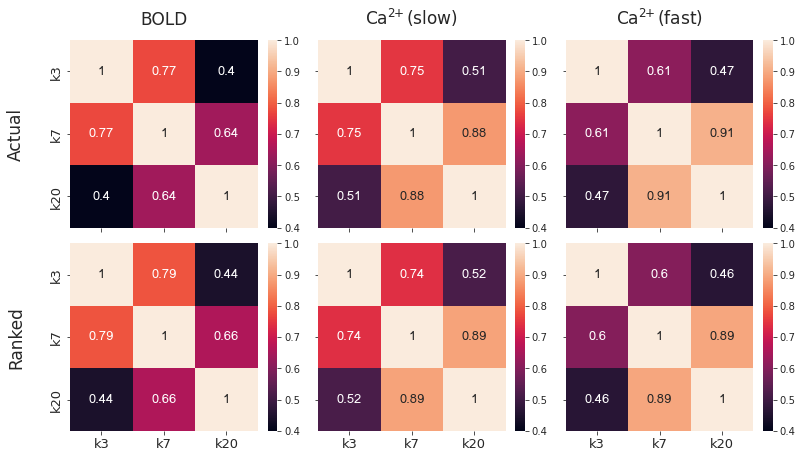

In [150]:
fig, axes = create_figure(2, 3, (11, 6.2), 'all', 'all', tight_layout=False, constrained_layout=True)

for i, dd in enumerate([h_all, hr_all]):
    for j, (mode, x) in enumerate(dd.items()):
        ax = axes[i, j]
        sim = dist2sim(sp_dist.squareform(sp_dist.pdist(
            X=x[:, np.isnan(x).sum(0) == 0],
            metric='correlation',
        )))
        sns.heatmap(
            data=sim,
            fmt='.2g',
            annot=True,
            square=True,
            cmap='rocket',
            cbar_kws={'shrink': 1},
            annot_kws={
                'fontsize': kwargs['annot_fontsize'],
                'fontname': kwargs['annot_fontname']},
            vmin=0.4,
            vmax=1.0,
            ax=ax,
        )
        tick_labels = [f"k{k}" for k in results]
        ax.set(
            xticklabels=tick_labels,
            yticklabels=tick_labels,
        )
        ax.tick_params(axis='both', labelsize=13)
        if i == 0:
            ax.set_title(mode, fontsize=17, y=1.05)
            if j == 0:
                ax.set_ylabel('Actual', labelpad=25, fontsize=17)
        else:
            if j == 0:
                ax.set_ylabel('Ranked', labelpad=25, fontsize=17)
                
fig.savefig(pjoin(fig_dir, 'all_k_sim.png'), **kws_fig)
plt.show()